# Deux conteneurs
## filebench : filemicro_seqread vs filemicro_seqread_eachone
### Tester la soft limite
#### Description
Le but de cette expérience est de tester la `soft` limite.

On se place dans un scénario où deux conteneurs exécutant des charges de travail différentes (`filemicro_seqread_eachone` qui sera détaillée plus tard et `filemicro_seqread` avec un fichier de 2GB) sont lancés et où l'administrateur système ne sait pas trop comment fixer cette limite. Il y aura donc trois cas :

1. Le premier dans lequel les deux conteneurs ont une `soft` limite égale à 1GB.
2. Le deuxième dans lequel les deux conteneurs ont une `soft` limite égale 1.5GB (soit la moitié de la mémoire de la machine).
3. Le dernier dans lequel le conteneur exécutant la charge de travail `filemicro_seqread_eachone` voit sa limite fixée à 2GB et l'autre à 1GB (deux tiers pour l'un et un tiers pour l'autre).

#### La `max` limite
Cette limite (aussi connue comme étant la `high` limite) indique la quantité de mémoire qu'un cgroup peut possèder avant que l'invocation de l'Out Of Memory (OOM) killer.

Comme les autres limites elle a été introduite par [Johannes Weiner en 2015](http://lkml.iu.edu/hypermail//linux/kernel/1501.1/00682.html). Les différentes limites sont décrites dans le fichier [Documentation/cgroup-v1/memory.txt](https://elixir.bootlin.com/linux/latest/source/Documentation/cgroup-v1/memory.txt).

#### La `soft` limite
Cette limite peut-être dépassée tant qu'elle n'est pas supérieure à la `max` limite et qu'il n'y a pas de contention.

Si le système d'exploitation détecte de la contention mémoire les cgroups mémoires verront leurs mémoires converger vers leurs `soft` limites. Néanmoins il n'y a aucune garantie sur le fait qu'un cgroup ne soit pas en dessous de sa `soft` limite en cas de grosse contention mémoire.

Les conteneurs sont organisées de manière hiérarchique via un arbre rouge-noir mais cette limite n'est pas traitée de manière hiérarchique.

#### Environnement 
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 2 coeurs.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

Chaque conteneur est lancé avec une `max` limite fixée à 3GB.

#### filemicro_seqread_eachone
Pour cette expérience une charge de travail nommée `filemicro_seqread_eachone` a été développée.

Cette charge de travail consiste à lire deux fichiers de tailles très différentes (1GB contre 10GB de base). À chaque itération les deux fichiers sont lus avec un pas de 1MB.

L'algorithme est le suivant :
```wsl
# Single threaded sequential reads (1MB I/Os) on a 1G file then on a 10G file.

# Global defines.
set $dir=/tmp
set $cached=false
set $iosize=1m
set $nthreads=1

# Specific defines.
set $small_filesize=1g
set $large_filesize=10g

define file name=smallfile,path=$dir,size=$small_filesize,prealloc,reuse,cached=$cached
define file name=largefile,path=$dir,size=$large_filesize,prealloc,reuse,cached=$cached

define process name=filereader,instances=1
{
  thread name=filereaderthread,memsize=10m,instances=$nthreads
  {
    flowop read name=seqread_smallfile,filename=smallfile,iosize=$iosize
    flowop read name=seqread_largefile,filename=largefile,iosize=$iosize
  }
}
```

#### Résultats attendus
Il semble naturel que les performances des conteneurs lorsqu'ils sont exécutés avec une `soft` limite fixée à 1GB soient inférieures à celles obtenues lorsqu'ils voient leurs limites fixées à 1.5GB.

Dans le cas où les conteneurs n'ont pas la même limite les performances du conteneur disposant d'une `soft` limite plus élevées devraient être plus élevées.

#### Algorithme de l'expérience
```bash
#! /usr/bin/env bash
# SPDX-License-Identifier: MPL-2.0

if [ $# -ne 2 ]; then
	echo "Usage: ${0} soft_limit0 soft_limit1" 1>&2

	exit 1
fi

# Launch containers as detached, set their max limits to 3G, their soft limits
# to given arguments and get their ids.
id0=$(docker run -d --memory 3G --memory-reservation $1 filebench)
id1=$(docker run -d --memory 3G --memory-reservation $2 filebench)

# Echo nothing to the files to emtpy them.
echo > ~/filemicro_seqread_${1}
echo > ~/filemicro_seqread_eachone_${2}

# Run each benchmark once so their files will be prepared for the next times and
# they will begin to read files approximately at the same time.
docker exec $id0 ./filebench -f workloads/filemicro_seqread.f &
docker exec $id1 ./filebench -f workloads/filemicro_seqread_eachone.f &

wait
wait

# Run each benchmark 10 times to compute mean and standard deviation.
for i in {1..10}; do
	docker exec $id0 ./filebench -f workloads/filemicro_seqread.f &>> ~/filemicro_seqread_${1} &
	docker exec $id1 ./filebench -f workloads/filemicro_seqread_eachone.f &>> ~/filemicro_seqread_eachone_${2} &

	wait
	wait
done

docker stop $id0 $id1
docker rm $id0 $id1
```

#### Résultats obtenus
Le conteneur A exécute la charge de travail `filemicro_seqread` avec un fichier de 2GB tandis que le conteneur B exécute la charge de `filemicro_seqread_eachone`.

Chaque conteneur est d'abord exécuté seul afin de mesurer ses performances dans le cas idéal où il est isolé.
Les conteneurs sont ensuite exécutés par paire.

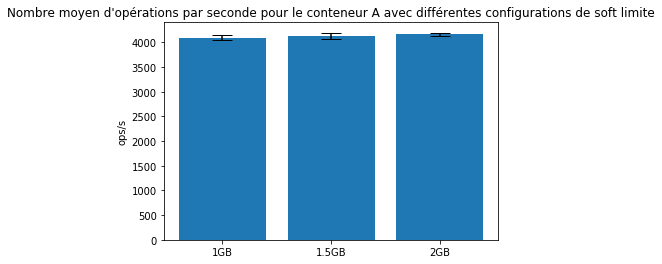

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

means = []
stds = []

for file in ['filemicro_seqread_alone_1G.csv', 'filemicro_seqread_alone_1.5G.csv', 'filemicro_seqread_alone_2G.csv']:
    df = pd.read_csv(file, ';')
    values = df.values

    means.append(values.mean(0)[1])
    stds.append(values.std(0)[1])
    
# xtick labels for the bar chart.
names = ['1GB', '1.5GB', '2GB']
x_pos = np.arange(len(names))

# Axis and figure initialization.
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr = stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
ax.set_ylabel('ops/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_title("Nombre moyen d'opérations par seconde pour le conteneur A avec différentes configurations de soft limite")

# Print the figure.
plt.show()

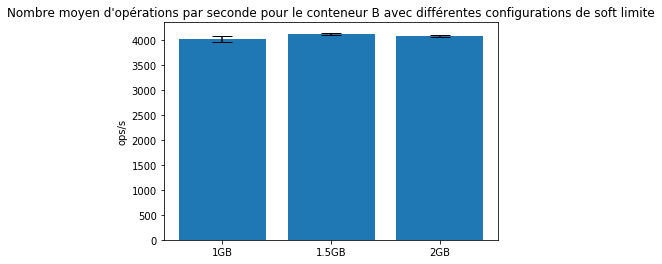

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

means = []
stds = []

for file in ['filemicro_seqread_eachone_alone_1G.csv', 'filemicro_seqread_eachone_alone_1.5G.csv', 'filemicro_seqread_eachone_alone_2G.csv']:
    df = pd.read_csv(file, ';')
    values = df.values

    means.append(values.mean(0)[1])
    stds.append(values.std(0)[1])
    
# xtick labels for the bar chart.
names = ['1GB', '1.5GB', '2GB']
x_pos = np.arange(len(names))

# Axis and figure initialization.
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr = stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
ax.set_ylabel('ops/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_title("Nombre moyen d'opérations par seconde pour le conteneur B avec différentes configurations de soft limite")

# Print the figure.
plt.show()

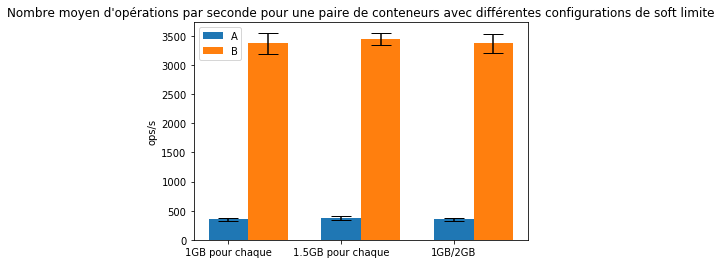

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# lists for the bar chart (A is first container, B is second (see above)).
A_means = []
A_stds = []

B_means = []
B_stds = []

for file in ['filemicro_seqread_1G.csv', 'filemicro_seqread_1.5G.csv', 'filemicro_seqread_1G.csv']:
    # Get data from CSV file.
    df = pd.read_csv(file, ';')
    values = df.values

    # Computing mean and standard deviation.
    # values is a numpy.ndarray i.e an array of tuples.
    # mean() and std() take an axis as argument and return a tuple.
    # [1] permits to obtain second member of tuple.
    A_means.append(values.mean(0)[1])
    A_stds.append(values.std(0)[1])

for file in ['filemicro_seqread_eachone_1G.csv', 'filemicro_seqread_eachone_1.5G.csv', 'filemicro_seqread_eachone_2G.csv']:
    df = pd.read_csv(file, ';')
    values = df.values

    B_means.append(values.mean(0)[1])
    B_stds.append(values.std(0)[1])
    
# xtick labels for the bar chart.
names = ['1GB pour chaque', '1.5GB pour chaque', '1GB/2GB']
x_pos = np.arange(len(names))

# Axis and figure initialization.
fig, ax = plt.subplots()
# The width of the bars.
WIDTH = .35
group0 = ax.bar(x_pos, A_means, WIDTH, yerr = A_stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
group1 = ax.bar(x_pos + WIDTH, B_means, WIDTH, yerr = B_stds, align = 'center', capsize = 10)
ax.set_ylabel('ops/s')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.legend((group0[0], group1[0]), ('A', 'B'))
ax.set_title("Nombre moyen d'opérations par seconde pour une paire de conteneurs avec différentes configurations de soft limite")

# Print the figure.
plt.show()

Les résultats sont plutôt stables comme en témoignent les écarts-types plutôt restreints.

La valeur idéale pour chaque conteneur semble se situer vers 4000 ops/s.

Les valeurs pour `filemicro_seqread_eachone` correspondent à la somme des lectures sur chaque fichier. Le nombre de lecture effectuée sur chaque fichier est à peu près identique donc on a $total\_reads \approx small\_file\_reads * 2 \approx large\_file\_reads * 2$. Ceci est dû au fait que chaque fichier est lu lors d'une itération de la charge de travail.

Étrangement, On peut voir qu'il n'y a pas de grosse variation entre les trois configurations de `soft` limite.

Le conteneur exécutant la charge de travail `filemicro_seqread` a toujours des performances très faibles (environ 500 ops/s contre environ 3000 ops/s normalement).

L'exécution de l'autre conteneur semble bien se dérouler car son nombre d'opérations par seconde est sensible à celui des précédentes expériences (environ 3000 ops/s contre environ 4000 ops/s quand exécuté seul).

#### Conclusion
Il est compliqué de trancher aisément sur les résultats obtenus néanmoins il y a clairement un conteneur qui s'exécute avec une qualité de service correcte tandis que l'autre n'atteint pas cette dernière.

Il faudrait relancer une expérience plus simple et monitorer la consommation mémoire de chaque charge de travail.

En effet, les faibles performances de la charge `filemicro_seqread` peuvent venir du fait que son conteneur ne dispose jamais d'1GB de mémoire. De plus, d'après les expériences précédentes 1GB ne suffit pas à garantir une exécution performante.